In [1]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay

from utils import get_trajectory, get_position, next_position, my_odometry

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.6
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0}


In [2]:
plt.rcParams['figure.figsize'] = [7, 7]

In [3]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [4]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [5]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

In [6]:
env.reset()
traj = get_trajectory(env)

/home/giulio/prog/duckrace_simulator/utils.py:101: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [7]:
traj[:10]

array([[1.47224186, 0.89882168],
       [1.46327478, 0.99399287],
       [1.46667284, 1.09337466],
       [1.47114545, 1.19275645],
       [1.47026898, 1.28107248],
       [1.44334587, 1.36818113],
       [1.39329816, 1.42978918],
       [1.32102126, 1.4597663 ],
       [1.24019591, 1.4699859 ],
       [1.14303777, 1.47681769]])

In [8]:
pose = get_position(env)
pose

Position(x=0.7019999, y=1.34470641, theta=0.0)

In [9]:
from scipy import spatial

In [10]:
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])

In [11]:
traj[index]

array([0.72770678, 1.47150851])

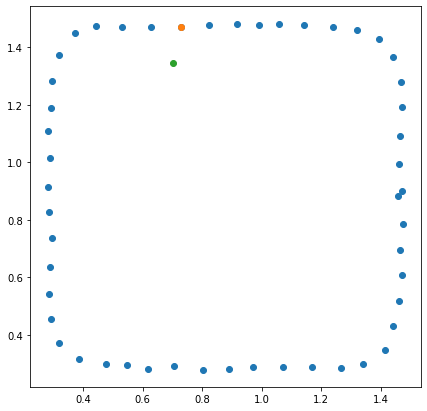

In [12]:
# Rotate the trajectory so that the agent is facing the same direction as the trajectory
plt.scatter(*traj.T)
plt.scatter(*traj[index])
plt.scatter(pose.x, pose.y)

In [13]:
from scipy.optimize import minimize

TODO: Considerare il delay nella odometria

In [50]:
delta_time = 1.0 / env.frame_rate

def loss(x, pose, trajectory, index, last_actions, phi):
    val = 0
    x = x.reshape(-1, 2)
    p1 = pose
    # To consider delay
    for i, el in enumerate(np.concatenate((last_actions, x))):
        p1 = my_odometry(p1, delta_time, el, speed=12)
        val += (phi**i)*((trajectory[index][0]-p1.x)**2 + (trajectory[index][1]-p1.y)**2)
    return val

NB Apparently there is a delay of 0.15s (line 750)

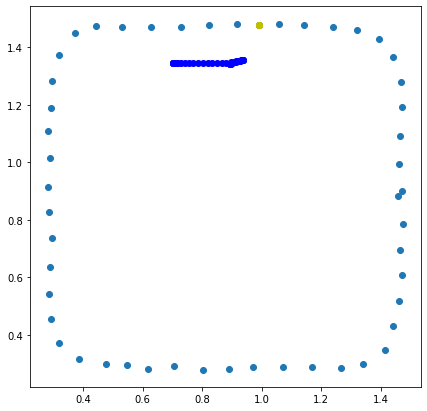

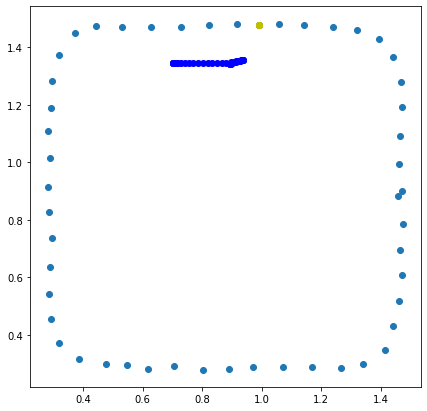

In [47]:
horizon_len = 5
simulation_len = 40

delay = round(0.15/delta_time)+7

horizon_len = horizon_len * 2

bnds = list(((-1, 1) for _ in range(horizon_len)))

env.reset()
pose = get_position(env)
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index = index - 3
plt.scatter(*traj.T)
actions = [[0,0] for _ in range(delay)]
loss_val = []
odoms = [pose]
poses = []
for _ in range(simulation_len):
    x0 = np.random.standard_normal(horizon_len)
    res = minimize(loss, x0, args=(pose, traj, index, np.array(actions[-delay:]), 0.8), method="L-BFGS-B", bounds=bnds)
    loss_val.append(res.fun)
    action = res.x[:2]
    # action = myfminunc(traj, index, pose)
    actions.append(action)
    obs, reward, done, info = env.step(action)
    if reward == -1000:
        print("Collision")
        break
    # Test odometry
    p = my_odometry(pose, delta_time, actions[-delay], speed=12)
    odoms.append(p)
    try:
        pose = get_position(env)
    except ValueError:
        print(env.cartesian_from_weird(env.cur_pos, env.cur_angle))
        break
    poses.append(pose)
    # print(loss(np.array([0,1]*int(horizon_len/2)).reshape(-1), pose, traj, index))
    plt.scatter(*traj[index], c='y')
    plt.scatter(pose.x, pose.y, marker="o", c="b")
    # Test odometry
    # plt.scatter(p.x, p.y, marker="*", c="r")
    # plt.imshow(obs)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    # index = index-1
    if index < 0:
        index = traj.shape[0]-1

In [49]:
import optuna

In [51]:
def objective(trial):
    horizon_len = trial.suggest_int('horizon_len', 1, 20)
    delay = trial.suggest_int('delay', 1, 15)
    phi = trial.suggest_float('phi', 0, 1)
    simulation_len = 40
    horizon_len = horizon_len * 2

    bnds = list(((-1, 1) for _ in range(horizon_len)))

    env.reset()
    pose = get_position(env)
    distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
    index = index - 3
    plt.scatter(*traj.T)
    actions = [[0,0] for _ in range(delay)]
    for _ in range(simulation_len):
        x0 = np.random.standard_normal(horizon_len)
        res = minimize(loss, x0, args=(pose, traj, index, np.array(actions[-delay:]), phi), method="L-BFGS-B", bounds=bnds)
        action = res.x[:2]
        actions.append(action)
        obs, reward, done, info = env.step(action)
        if reward == -1000:
            print("Collision")
            break
        try:
            pose = get_position(env)
        except ValueError:
            print(env.cartesian_from_weird(env.cur_pos, env.cur_angle))
            break
        if index < 0:
            index = traj.shape[0]-1
    return res.fun

[I 2021-12-31 12:56:30,482] A new study created in memory with name: no-name-af89db97-ac23-4e93-8dc5-3097036d2c15


KeyboardInterrupt: 

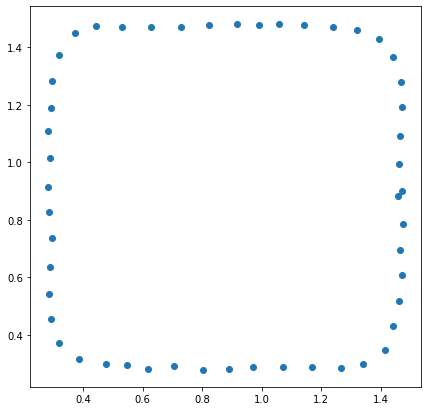

In [52]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

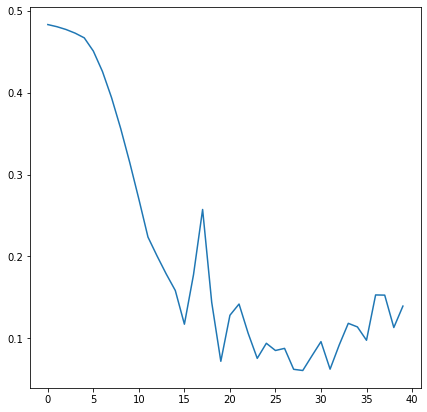

In [48]:
plt.plot(loss_val)

In [33]:
actions

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([0.40619599, 1.        ]),
 array([0.53997948, 1.        ]),
 array([0.4439388, 1.       ]),
 array([0.45675287, 1.        ]),
 array([1., 1.]),
 array([-1.,  1.]),
 array([-1., -1.]),
 array([-0.65888825, -1.        ]),
 array([-0.42652097,  1.        ]),
 array([-1., -1.]),
 array([1.       , 0.2977749]),
 array([-1.,  1.]),
 array([-1.,  1.]),
 array([1., 1.]),
 array([-1., -1.]),
 array([1., 1.]),
 array([-1., -1.]),
 array([-1.        , -0.25072736]),
 array([1., 1.]),
 array([ 1., -1.]),
 array([-1.,  1.]),
 array([-1.,  1.]),
 array([ 1., -1.]),
 array([ 1., -1.]),
 array([-1., -1.]),
 array([1., 1.]),
 array([-1.        ,  0.18889156]),
 array([ 1., -1.]),
 array([1.        , 0.71122448]),
 array([1., 1.])